# Week 5 GAN assignment:

# Generating Monet-Style Images Using GANs

## 1. Description of the Problem

### Problem Overview
### This project involves the creation of a GANs capable of generating images that mimic the style of Monet. By leveraging modern machine learning techniques such as downsampling and upsampling to automate the generation of artistic images that resemble the unique style of Monet's impressionist paintings. This notebook shows potential towards the creative art domain. 

### Data Description
### The dataset is divided into two parts: Monet paintings and real landscape photos. The Monet dataset includes various works by the artist, showcasing his iconic brushwork and color palette. The real photos dataset consists of landscape images, serving as the input for our GAN model. Both datasets are processed to a uniform size of 256x256 pixels, preparing them for the training process.

## 2. Exploratory Data Analysis (EDA)
### Visualization and Insights
### Using the display_images function, you can visually explore the 10 samples from the Monet paintings and 10 real photo examples. This exploration reveals the diversity in colors, subjects, and styles present in Monet's paintings compared to the more realistic hues and compositions of the landscape photos. This diversity is crucial for the GAN's learning process, as it must capture and replicate the distinct impressionist style of Monet's artwork.

## 3. Model Building and Training
### GAN Architecture
### The GAN consists of two main components: a generator and a discriminator. The generator network is tasked with transforming input landscape photos into outputs resembling Monet's paintings. Conversely, the discriminator network distinguishes between actual Monet paintings and the generated images. The architecture incorporates downsample and upsample layers, alongside dropout techniques, to facilitate this complex transformation process.

### Preprocessing
### The images are normalized to a [0, 1] scale to ensure consistency in model input. Additionally, images are resized to 256x256 pixels to standardize the dataset and streamline the training process.

### Training Process
### The model is trained using Adam optimizers with specific learning rates to optimize both the generator and discriminator networks. The training involves generator loss, discriminator loss, and cycle consistency loss functions, each playing a pivotal role in refining the generated images' quality. TensorFlow's @tf.function decorator is utilized to compile the training step into a graph, enhancing execution speed and efficiency.
### Please note that without the normalization step (Norm function) the learning process within the epochs does not converge.

## 4. Results
### Generated Images
### The GAN successfully generates images that capture the essence of Monet's style, as demonstrated by side-by-side comparisons with actual Monet paintings and input photos. These comparisons highlight the model's ability to replicate Monet's distinctive color palettes and textures.

### Loss Metrics
### Training loss plots for the generator and discriminator reveal how the model's performance evolved over epochs, showcasing gradual improvement and stabilization in generating Monet-style images.

### Discussion
### While the generated images showcase notable strengths, such as accurate color palettes and impressionist textures, areas for improvement remain, particularly in achieving Monet's unique brushstroke style. Patterns and anomalies in the generated images suggest areas for further refinement and optimization. One possible improvement here is to increase the size of the individual convolutional layers to capture larger brush strokes and another possibility is to add more layers within the network to learn more complex patterns. One can see from the generated images below there is a grid like pattern which is a sign it is generated by a machine instead of a person.

## 5. Conclusion and Discussion
### This project demonstrates the potential of GANs to generate convincing Monet-style images, marking a successful intersection of AI and art. Challenges encountered in training stability and model convergence were addressed through architectural adjustments and hyperparameter tuning (example adding the Norm layer function and increasing dropout). Insights gained emphasize the importance of dataset quality and architecture design in achieving high-quality generated images. I think more examples of the Monet images as only 300 image JPG files were provided as apposed to 7000+ images of real photos. Deep NNs require a lot of data to be able to learn the patterns correctly. Future work could explore different GAN architectures or incorporate additional datasets to enhance model robustness and output diversity.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# This notebook was run on Google Colab with a Tesla A100 GPU:

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

!nvidia-smi

Wed Mar  6 22:50:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              52W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load images and display them here:

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Activation, Add, UpSampling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
import os
import pickle

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from io import BytesIO
from PIL import Image

import matplotlib.pyplot as plt
import math

global max_images_to_import

#max_images_to_import = 10
# change to 10,000 to increase the accuracy:
#max_images_to_import = 10000

max_images_to_import = 10000

DropOut = .7


#show_image_generation_per_number = 20
#show_image_generation_per_number = 1
#show_image_generation_per_number = 100
show_image_generation_per_number = 700

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 3
BATCH_SIZE = 1

EPOCHS = 10

LAMBDA = 10  # For cycle consistency loss


import pickle
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

# Function to load data from pickle file
def load_images(pickle_file, max_images=max_images_to_import):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    images = []
    for i, (key, value) in enumerate(data.items()):
        if i >= max_images:  # Only load up to max_images images
            break
        image = Image.open(BytesIO(value))

        image_array = img_to_array(image)
        image_array = image_array / 255.0

        #print(image_array.dtype, image_array.min(), image_array.max())
        images.append(image_array)
    return images


monet_images = load_images( "/content/drive/My Drive/GANs/Painter/all_monet.pickle")
photo_images = load_images("/content/drive/My Drive/GANs/Painter/all_photo.pickle")


import matplotlib.pyplot as plt
import math
import random

def display_images(images, title, num_images_to_display=10):

    num_images_to_display = min(num_images_to_display, len(images))

    selected_images = random.sample(images, num_images_to_display)

    cols = 5
    rows = math.ceil(num_images_to_display / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
    fig.suptitle(title, fontsize=16)

    if rows * cols != 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, image in enumerate(selected_images):
        axes[i].imshow(image)
        axes[i].axis('off')

    for ax in axes[num_images_to_display:]:
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


display_images(photo_images, "Randomly Selected Photo Images")
print()
print()
print()
display_images(monet_images, "Randomly Selected Monet Images")



def decode_image(image):
    #image = tf.image.decode_jpeg(image, channels=3)
    image_tensor = tf.cast(image, tf.float32)
    min_val = tf.reduce_min(image_tensor)
    max_val = tf.reduce_max(image_tensor)
    image_tensor = (image_tensor - min_val) / (max_val - min_val)
    image_tensor = tf.reshape(image_tensor, [1, 256, 256, 3])
    return image_tensor


# Convert the lists to TensorFlow datasets
photo_ds = tf.data.Dataset.from_tensor_slices(photo_images)
monet_ds = tf.data.Dataset.from_tensor_slices(monet_images)

# Apply the decode_image function using the .map() method
photo_ds = photo_ds.map(lambda x: decode_image(x))
monet_ds = monet_ds.map(lambda x: decode_image(x))





Output hidden; open in https://colab.research.google.com to view.

In [4]:
import tensorflow as tf

class Norm(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(Norm, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset


In [5]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True, stride=2):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'norm':
      result.add(Norm())

  result.add(tf.keras.layers.LeakyReLU(0.1))

  return result

In [6]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False, stride=2, crop = None):

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=stride,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
  if crop is not None:
    result.add(
        tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0)))
    )

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'norm':
    result.add(Norm())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(DropOut))
#leaky relu
  result.add(tf.keras.layers.LeakyReLU(0.1))

  return result

In [7]:
# Define the generators and discriminators

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D

from tensorflow.keras import layers



from keras.layers import Input, Conv2D, Activation, Add, UpSampling2D, BatchNormalization, Conv2DTranspose
from keras.models import Model

def build_generator(output_channels=3, norm_type='batchnorm'):
    down_stack = [
        downsample(64, 4, norm_type, apply_norm=False),
        downsample(128, 4, norm_type),
        downsample(256, 4, norm_type),
        downsample(512, 4, norm_type),
        downsample(512, 4, norm_type),
        downsample(512, 4, norm_type),
        downsample(512, 4, norm_type),
        downsample(512, 4, norm_type, stride=2),
    ]

    up_stack = [
        upsample(512, 4, norm_type, apply_dropout=True,stride = 2),

        #upsample(512, 4, norm_type, apply_dropout=True, crop = True),
        upsample(512, 4, norm_type, apply_dropout=True),
        upsample(512, 4, norm_type, apply_dropout=True),
        upsample(512, 4, norm_type),
        upsample(256, 4, norm_type),
        upsample(128, 4, norm_type),
        upsample(64, 4, norm_type),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 4, strides=2,
        padding='same', kernel_initializer=initializer,
        activation='tanh')

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

    # Downsampling through the model
    #print("got here 1")
    skips = []
    for down in down_stack:
      #print(f"Before downsampling, shape: {x.shape}")
      x = down(x)
      #print(f"AFTER downsampling, shape: {x.shape}")
      skips.append(x)

    skips = reversed(skips[:-1])

    #print("got here 2")
    # Upsampling and establishing the skip connections
    #for up, skip in zip(up_stack, skips):
    #  up.build(x.shape)
    #  x = up(x)
    #  x = concat([x, skip])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        up.build(x.shape)  # Prepare the layer to be compatible with the input shape
        #print(f"Before upsampling, shape: {x.shape}")  # Print the shape before upsampling
        x = up(x)
        #print(f"After upsampling, shape: {x.shape}")  # Print the shape after upsampling
        # Concatenate the upsampled output with the corresponding skip layer output
        x = concat([x, skip])
        #print(f"After concatenation, shape: {x.shape}")  # Print the shape after concatenation


    #print("got here 3")
    x = last(x)

    #print(f"After last function, shape: {x.shape}")
    return tf.keras.Model(inputs=inputs, outputs=x)



from keras.layers import Input, Conv2D, Activation, Add, UpSampling2D, BatchNormalization, Conv2DTranspose
from keras.models import Model

from keras.layers import Input, Conv2D, LeakyReLU, Dropout, Flatten, Dense
from keras.initializers import RandomNormal
from keras.models import Model


def build_discriminator(norm_type='batchnorm', target=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    x = inp

    if target:
      tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
      x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(64, 4, norm_type, False)(x)
    down2 = downsample(128, 4, norm_type)(down1)
    down3 = downsample(256, 4, norm_type)(down2)
    down4 = downsample(256, 4, norm_type)(down3)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer,
        use_bias=False)(zero_pad1)

    if norm_type.lower() == 'batchnorm':
      norm1 = tf.keras.layers.BatchNormalization()(conv)
    elif norm_type.lower() == 'norm':
      norm1 = Norm()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer)(zero_pad2)

    if target:
      return tf.keras.Model(inputs=[inp, tar], outputs=last)
    else:
      return tf.keras.Model(inputs=inp, outputs=last)


OUTPUT_CHANNELS = 3


# Instantiate the CycleGAN models
generator_g = build_generator(OUTPUT_CHANNELS, norm_type='norm')  # Monet to Photo
generator_f = build_generator(OUTPUT_CHANNELS, norm_type='norm')  # Photo to Monet
discriminator_x = build_discriminator(norm_type='norm', target=False)  # Discriminator for Photos
discriminator_y = build_discriminator(norm_type='norm', target=False)  # Discriminator for Monet paintings




# Optimizers and training step is here...

In [8]:


# Define the optimizers
gen_opt = Adam(2e-4, beta_1=0.1)
disc_opt = Adam(2e-4, beta_1=0.1)

# Define the loss functions and the cycle consistency loss
def discriminator_loss(real, generated):
    real_loss = tf.reduce_mean((real - 1) ** 2)
    generated_loss = tf.reduce_mean(generated ** 2)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(generated):
    return tf.reduce_mean((generated - 1) ** 2)


def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

# Define the training step
@tf.function
def train_step(real_x, real_y):

    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates A -> B
        # Generator F translates B -> A.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Discriminator output
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    gen_opt.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    gen_opt.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    disc_opt.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    disc_opt.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))


    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss, total_cycle_loss




In [9]:

gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Combine generator and discriminator variables
all_trainable_variables = generator_g.trainable_variables + \
                          generator_f.trainable_variables + \
                          discriminator_x.trainable_variables + \
                          discriminator_y.trainable_variables

# Explicitly build the optimizer
gen_opt.build(all_trainable_variables)
disc_opt.build(all_trainable_variables)



avg_gen_g_loss, avg_gen_f_loss, avg_disc_x_loss, avg_disc_y_loss, avg_cycle_loss = [], [], [], [], []

# Training loop
for epoch in range(EPOCHS):
    gen_g_loss_list, gen_f_loss_list, disc_x_loss_list, disc_y_loss_list, cycle_loss_list = [], [], [], [], []
    for image_x, image_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
        #train_step(image_x, image_y)
        #print(f"Epoch: {epoch+1} completed")

        # Capture the loss values
        gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss, cycle_loss = train_step(image_x, image_y)

        # Accumulate the loss values
        gen_g_loss_list.append(gen_g_loss.numpy())
        gen_f_loss_list.append(gen_f_loss.numpy())
        disc_x_loss_list.append(disc_x_loss.numpy())
        disc_y_loss_list.append(disc_y_loss.numpy())
        cycle_loss_list.append(cycle_loss.numpy())

    # Calculate and store the average loss for the epoch
    avg_gen_g_loss.append(np.mean(gen_g_loss_list))
    avg_gen_f_loss.append(np.mean(gen_f_loss_list))
    avg_disc_x_loss.append(np.mean(disc_x_loss_list))
    avg_disc_y_loss.append(np.mean(disc_y_loss_list))
    avg_cycle_loss.append(np.mean(cycle_loss_list))

    print(f"Epoch {epoch + 1}/{EPOCHS}:")
    print(f"Generator G Loss: {avg_gen_g_loss[-1]}, Generator F Loss: {avg_gen_f_loss[-1]}")
    print(f"Discriminator X Loss: {avg_disc_x_loss[-1]}, Discriminator Y Loss: {avg_disc_y_loss[-1]}")
    print(f"Cycle Loss: {avg_cycle_loss[-1]}")



Epoch 1/10:
Generator G Loss: 4.0608601570129395, Generator F Loss: 4.017240524291992
Discriminator X Loss: 1.290287971496582, Discriminator Y Loss: 1.2764290571212769
Cycle Loss: 3.292433738708496
Epoch 2/10:
Generator G Loss: 2.5604171752929688, Generator F Loss: 2.5376555919647217
Discriminator X Loss: 0.6066967844963074, Discriminator Y Loss: 0.5974065661430359
Cycle Loss: 2.18351149559021
Epoch 3/10:
Generator G Loss: 2.052021026611328, Generator F Loss: 2.0528385639190674
Discriminator X Loss: 0.5726908445358276, Discriminator Y Loss: 0.559354841709137
Cycle Loss: 1.7104365825653076
Epoch 4/10:
Generator G Loss: 1.879879117012024, Generator F Loss: 1.8798359632492065
Discriminator X Loss: 0.5620801448822021, Discriminator Y Loss: 0.5485224723815918
Cycle Loss: 1.5415842533111572
Epoch 5/10:
Generator G Loss: 1.6709256172180176, Generator F Loss: 1.674220085144043
Discriminator X Loss: 0.5485200881958008, Discriminator Y Loss: 0.5413609743118286
Cycle Loss: 1.3356469869613647
Epoc

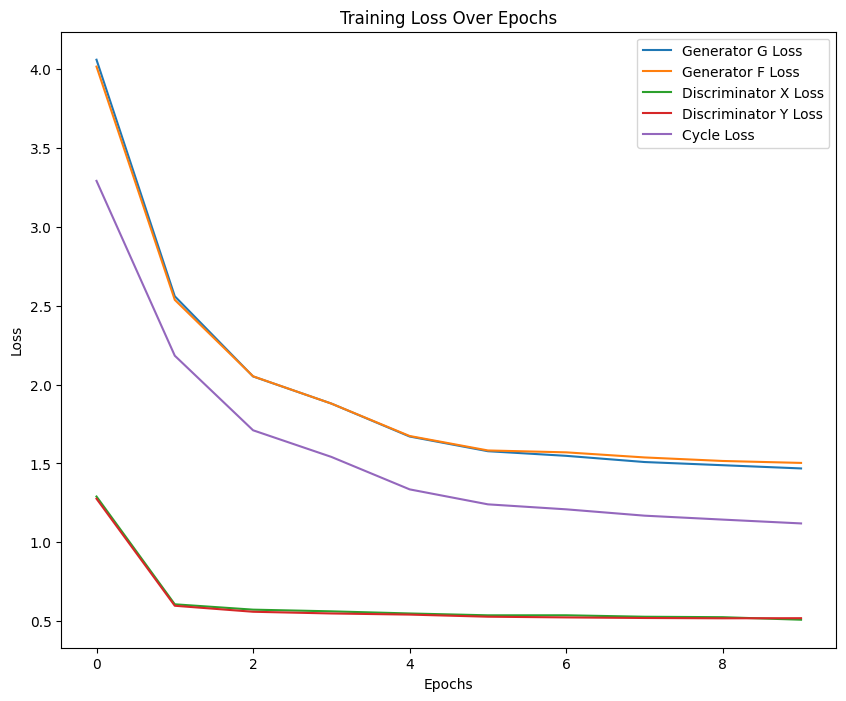

In [10]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(10, 8))
plt.plot(avg_gen_g_loss, label='Generator G Loss')
plt.plot(avg_gen_f_loss, label='Generator F Loss')
plt.plot(avg_disc_x_loss, label='Discriminator X Loss')
plt.plot(avg_disc_y_loss, label='Discriminator Y Loss')
plt.plot(avg_cycle_loss, label='Cycle Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
import tensorflow as tf
import numpy as np
import os
import tempfile
import zipfile

import random

generator_f = build_generator()  

# Function to generate and save images
def generate_and_save_images(model, num_images, output_dir):

    random.seed(42)

    i = 0

    for photo_image in photo_ds.take(len(photo_images)):
        generated_image = generator_g(photo_image, training=False)

        # Normalize images to the 0..1 range for RGB
        generated_image_normalized = np.clip(generated_image[0].numpy(), 0, 1)

        # Save the generated image

        img = tf.keras.preprocessing.image.array_to_img(generated_image_normalized)


        if i % show_image_generation_per_number == 0:  

          fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 

          # First subplot for the original image
          axs[0].imshow(photo_image[0])
          axs[0].set_title(f'Original Image {i+1}')
          axs[0].axis('off')  # Turn off axis

          # Second subplot for the generated image
          axs[1].imshow(img)
          axs[1].set_title(f'Generated Image {i+1}')
          axs[1].axis('off')  # Turn off axis

          # Display the figure with both images
          plt.show()

        img.save(os.path.join(output_dir, f'image_{i+1}.jpg'))

        i = i + 1

# Create a temporary directory to store images
with tempfile.TemporaryDirectory() as temp_dir:
    # Generate and save n images
    generate_and_save_images(generator_f, max_images_to_import, temp_dir)

    # Zip all the generated images
    zip_filename = "/content/drive/My Drive/GANs/Painter/images.zip"
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, dirs, files in os.walk(temp_dir):
            for file in files:
                zipf.write(os.path.join(root, file), arcname=file)

print(f"All generated images are zipped in {zip_filename}")


Output hidden; open in https://colab.research.google.com to view.